# Tacotron2

## Prepair for training

### Download Dataset

Mount Google Drive to store all checkpoints and datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download LJ dataset

In [ ]:
# %cd /content/drive/MyDrive/
# !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
# !tar -xf LJSpeech-1.1.tar.bz2

Download M-AILABS Russian dataset

In [ ]:
# %cd /content/drive/MyDrive/
# !wget http://www.caito.de/data/Training/stt_tts/ru_RU.tgz
# !tar -zxvf ru_RU.tgz
# # Rename directory
# !mv ru_RU M_AILABS_Ru

/content/drive/MyDrive


### Preprocess Dataset


In [11]:
import random

In [32]:
"""
Move all wav file to the common folder
Concat all text files into one
"""
def refactor_M_AILABS(sex='female', speaker_index=0
                      , dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/"
                      , out_dir="/content/drive/MyDrive/M_AILABS_Ru/"
                      , move_files=True
                      ):
  print(" *** Start refactoring... ***")
  path = f"{dataset_dit}{''if dataset_dit[-1] == '/' else '/'}by_book/{sex}"
  %cd $path
  speakers = !ls
  books_path = f"{path}/{speakers[speaker_index]}"
  %cd $books_path
  books_folders = !ls -d */ | cut -f1 -d'/'
  path = f"{out_dir}{''if out_dir[-1] == '/' else '/'}"
  %cd $path
  !mkdir wavs
  wavs_path = f"{path}wavs/"
  !touch mlbs_audio_text.txt
  for book in books_folders:
    cur_wavs_path = f"{books_path}/{book}/wavs/*"
    cur_text_path = f"{books_path}/{book}/metadata.csv"
    !cat $cur_text_path >> mlbs_audio_text.txt
    if move_files:
      !mv -v $cur_wavs_path $wavs_path
  print(" *** Refactoring finished! ***")

In [ ]:
# refactor_M_AILABS()

In [39]:
"""
M-Ailabs dataset has 2 strings of audio trascription -
raw and normalized
This function chooose one, based on argument 
and add wav file full path
"""
def transform_m_ailabs_text(file_name="mlbs_audio_text.txt",
                            new_file_name="mlbs_audio_text_transformed.txt",
                            dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/",
                            raw_data=False):
  write_file = open(dataset_dir+new_file_name, 'w', encoding='utf-8')
  with open(dataset_dir+file_name, 'r', encoding='utf-8') as read_file:
    for line in read_file:
      line = line.split('|')
      wav_file_path = f"{dataset_dir}wavs/{line[0]}.wav"
      new_line = f"{wav_file_path}|{line[1] if raw_data else line[2]}"
      write_file.write(new_line)

In [40]:
transform_m_ailabs_text()

In [42]:
"""
We should split data into 3 sets:
'train', 'test' and 'eval'
"""
def split_dataset(test_size=0.05, eval_size=0.01,
                  dataset_dir="/content/drive/MyDrive/M_AILABS_Ru/",
                  source_file_name="mlbs_audio_text_transformed.txt",
                  output_file_name_base="mlbs_audio_text",
                  shuffle=True):
  if test_size + eval_size >= 1:
    print("ERROR: (test_size + eval_size) must be less 1")
    return
  
  data = []
  with open(f"{dataset_dir}{source_file_name}",
            'r', encoding='utf-8') as read_file:
    for line in read_file:
      data.append(line)
  
  length = len(data)
  test_length = int(length * test_size)
  eval_length = int(length * eval_size)
  if shuffle:
    random.shuffle(data)
  test_data = data[: test_length]
  eval_data = data[test_length : test_length + eval_length]
  train_data = data[test_length + eval_length :]

  sets = {'test': test_data, 'eval': eval_data, 'train': train_data}
  for name, dataset in sets.items():
    with open(f"{dataset_dir}{output_file_name_base}_{name}.txt", 
              'w', encoding='utf-8') as file:
      for line in dataset:
        file.write(line)


In [43]:
split_dataset(shuffle=False)

### Install libs

In [ ]:
# !git clone https://github.com/NVIDIA/tacotron2.git

In [3]:
!git clone https://github.com/lightbooster/tacotron2.git
%cd tacotron2
!git checkout russian-cleaners

/content/tacotron2
Branch 'russian-cleaners' set up to track remote branch 'russian-cleaners' from 'origin'.
Switched to a new branch 'russian-cleaners'


In [5]:
%cd /content/tacotron2/

/content/tacotron2


In [6]:
!git submodule init; git submodule update

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/content/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'


In [ ]:
# %cd ..
# !git clone https://github.com/NVIDIA/apex
# %cd apex
# !pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
# %cd ../tacotron2

In [30]:
!cat requirements.txt

matplotlib==2.1.0
tensorflow==1.15.2
numpy==1.13.3
inflect==0.2.5
librosa==0.6.0
scipy==1.0.0
Unidecode==1.0.22
pillow


In [ ]:
!pip install apex
!pip install Unidecode
!pip install tensorflow==1.15.2

Change the dirrectory of wav files (for LJ dataset)

In [5]:
# !sed -i -- 's,DUMMY,../drive/MyDrive/LJSpeech-1.1/wavs,g' filelists/*.txt

## Train

In [44]:
%cd /content/tacotron2/

/content/tacotron2


### Hyperparams

In [66]:
training_files='../drive/MyDrive/M_AILABS_Ru/mlbs_audio_text_train.txt'
validation_files='../drive/MyDrive/M_AILABS_Ru/mlbs_audio_text_eval.txt'

output_directory = "../drive/MyDrive/M_AILABS_Ru/checkpoints"
log_directory = "../logs"

batch_size = 16
iters_per_checkpoint = 300
sampling_rate = 16000

hparams = f"batch_size={batch_size},\
            iters_per_checkpoint={iters_per_checkpoint},\
            training_files={training_files},\
            validation_files={validation_files},\
            sampling_rate={sampling_rate}"

### Pretrained weights

NVIDEA checkpoint and deleted language weights

In [ ]:
# checkpoint_path = "../drive/MyDrive/tacotron2_statedict.pt"
# !python train.py --output_directory=$output_directory --log_directory=$log_directory --hparams "$hparams" -c $checkpoint_path --warm_start

my checkpoint and saved weights

In [ ]:
checkpoint_path = "../drive/MyDrive/M_AILABS_Ru/checkpoints/checkpoint_600"
!python train.py --output_directory=$output_directory --log_directory=$log_directory --hparams "$hparams" -c $checkpoint_path

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Loading checkpoint '../drive/MyDrive/M_AILABS_Ru/checkpoints/checkpoint_600'
Loaded checkpoint '../drive/MyDrive/M_AILABS_Ru/checkpoints/checkpoint_600' from iteration 600
Epoch: 1
Train loss 601 0.230566 Grad Norm 1.354806 11.30s/it
Train loss 602 0.287618 Grad Norm 1.726918 10.65s/it
Train loss 603 0.332104 Grad Norm 1.636783 9.19s/it
Train loss 604 0.334033 Grad Norm 1.122555 10.18s/it
Train loss 605 0.252788 Grad Norm 1.660487 9.08s/it
Train loss 606 0.354600 Grad Norm 1.922877 8.62s/it
Train loss 607 0.364495 Grad N

### From the start

In [ ]:
# !python train.py --output_directory="../logs" --hparams "batch_size=16, iters_per_checkpoint=300" --checkpoint_path "../drive/MyDrive/LJSpeech-1.1/checkpoints/checkpoint_100"

## Eval

In [51]:
import torch

In [49]:
checkpoint_dir = "../drive/MyDrive/M_AILABS_Ru/checkpoints/"
checkpoint_name = "checkpoint_"
checkpoint_num = 600
checkpoint_path = checkpoint_dir + checkpoint_name + str(checkpoint_num)
checkpoint_path

'../drive/MyDrive/M_AILABS_Ru/checkpoints/checkpoint_600'

### WaveGlow

In [52]:
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow', pretrained=False)
checkpoint = torch.hub.load_state_dict_from_url('https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/19.09.0/files/nvidia_waveglowpyt_fp32_20190427')

# # Unwrap the DistributedDataParallel module
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

# # Apply the state dict to the model
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
_ = waveglow.eval()

Downloading: "https://github.com/nvidia/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/19.09.0/files/nvidia_waveglowpyt_fp32_20190427" to /root/.cache/torch/hub/checkpoints/nvidia_waveglowpyt_fp32_20190427


### Tacotron2

In [62]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [54]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [55]:
hparams = create_hparams()
hparams.sampling_rate = 16000

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [56]:
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval() 

## Testing

In [57]:
text = "Привет мир. Это я женский русский голос"

In [59]:
# preprocessing
sequence = np.array(text_to_sequence(text, ['russian_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)
sequence

tensor([[113, 114, 106,  99, 102, 116,  11, 110, 106, 114,   7,  11, 127, 116,
         112,  11, 129,  11, 104, 102, 111, 115, 108, 106, 107,  11, 114, 117,
         115, 115, 108, 106, 107,  11, 100, 112, 109, 112, 115]],
       device='cuda:0')

In [60]:
# run the models
with torch.no_grad():
    _, mel, _, _ = model.inference(sequence)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 16000

Warning! Reached max decoder steps


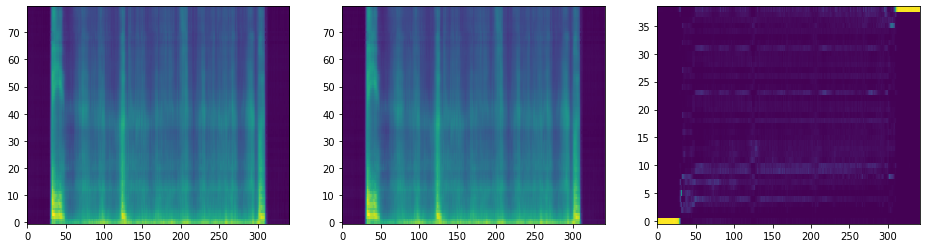

In [63]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
plt.show()

In [ ]:
plt.scatter(range(300), audio_numpy[:300].reshape(300))
plt.show()

In [64]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)